# Glass Classification

## Import stuff

In [1]:
import numpy as np
# print(np.__version__)

from IPython import display
import time

import pandas as pd


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from crysx_nn.network import visualize
from crysx_nn.network import back_propagation, back_propagation_fast
from crysx_nn.network import nn_optimize, nn_optimize_fast
from crysx_nn.network import forward_feed
from crysx_nn.network import errorFunc
from crysx_nn.network import errorFuncGrad
from crysx_nn.network import Softmax
from crysx_nn.network import binary_cross_entropy, binary_cross_entropy_grad
from crysx_nn.network import cross_entropy, cross_entropy_grad

# Import loss functions
from crysx_nn.loss import MSE_loss, MSE_loss_grad
from crysx_nn.loss import BCE_loss, BCE_loss_grad
# Import activation functions
from crysx_nn.activation import Sigmoid, Sigmoid_grad
from crysx_nn.activation import Softmax, Softmax_grad
from crysx_nn.activation import ReLU, ReLU_grad
# Import neural network functions
from crysx_nn.network import back_propagation, back_propagation_fast
from crysx_nn.network import nn_optimize, nn_optimize_fast
from crysx_nn.network import forward_feed


from tqdm.notebook import tqdm


# import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.python.eager import context


import torch, torchvision
rng = np.random.default_rng()
import time
from timeit import default_timer as timer

/Users/admin/opt/anaconda3/envs/performance/lib/python3.7/site-packages/crysx_nn/network.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Check if NumPy is linked with MKL or not

In [2]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/admin/opt/anaconda3/envs/performance/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/admin/opt/anaconda3/envs/performance/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/admin/opt/anaconda3/envs/performance/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/admin/opt/anaconda3/envs/performance/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include

## Start with the common stuff

In [3]:
nInputs = 9 # There would be 9 features that we would be using
nOutputs = 1
neurons_per_layer = [100,100,6]#
# activation_func_names = ['ReLU','ReLU', 'Softmax']# Use smaller learning rates with ReLU
activation_func_names = ['Sigmoid','Sigmoid', 'Softmax']# Use larger learning rates with Sigmoid
nLayers = len(neurons_per_layer)
eeta = 0.1#0.01
nEpochs=10000
batchSize = 164#nSamples
totSamples = 0


#### Activation function dictionary for all the frameworks

In [4]:
act_func_dict_PyTorch = {'Sigmoid':torch.nn.Sigmoid(),'ReLU':torch.nn.ReLU(),'ELU':torch.nn.ELU(), 'Hardshrink' : torch.nn.Hardshrink(),'Hardsigmoid':torch.nn.Hardsigmoid(),\
                 'Hardtanh':torch.nn.Hardtanh(),'Hardswish':torch.nn.Hardswish(),'LeakyReLU':torch.nn.LeakyReLU(),'LogSigmoid':torch.nn.LogSigmoid(),\
                 'Tanh':torch.nn.Tanh(),'Softmax':torch.nn.Softmax(dim=1),'Softmin':torch.nn.Softmin(dim=1),'LogSoftmax':torch.nn.LogSoftmax()}
act_func_dict_tensorflow = {'Sigmoid':'sigmoid','Softmax':'softmax','ReLU':'relu','LeakyReLU':'leakyrelu'}

## Visualize 

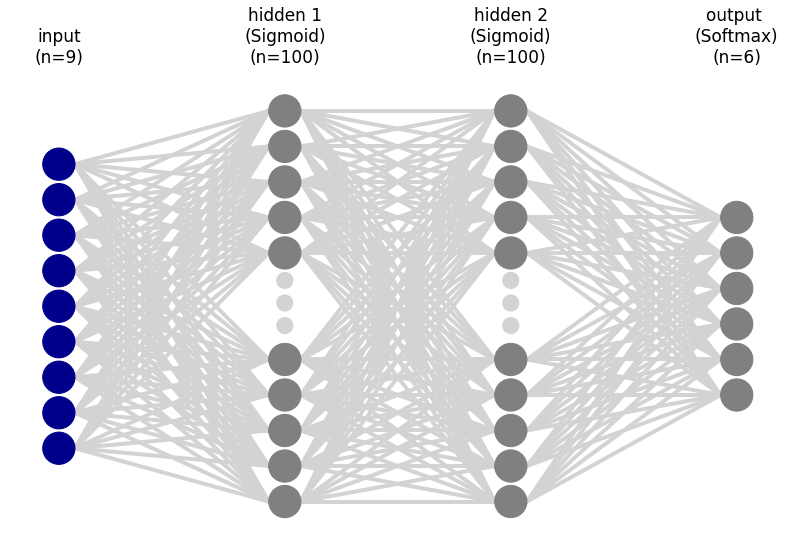

In [5]:
visualize(nInputs, neurons_per_layer, activation_func_names)

## Data
This is a Glass Identification Data Set from UCI. It contains 10 attributes including id. The response is glass type(discrete 7 values)

Id number: 1 to 214 

RI: refractive index

Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)

Mg: Magnesium

Al: Aluminum

Si: Silicon

K: Potassium

Ca: Calcium

Ba: Barium

Fe: Iron

Type of glass: (class attribute) -- 1 buildingwindowsfloatprocessed -- 2 buildingwindowsnonfloatprocessed -- 3 vehiclewindowsfloatprocessed -- 4 vehiclewindowsnonfloatprocessed (none in this database) -- 5 containers -- 6 tableware -- 7 headlamps

## Set inputs
Use all the input features

In [6]:
df = pd.read_csv('glass.data.csv',names=['Id','RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type'])
df

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
209,210,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,211,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,212,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,213,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


## We can drop the Id column

In [7]:
df = df.drop('Id',1)
df

/Users/admin/opt/anaconda3/envs/performance/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [8]:
print('Number of Null Values: ',df.isnull().sum().sum())

Number of Null Values:  0


## Data Analysis

In [9]:
df['Type'] = df['Type'].astype('category')
print(df.dtypes)
df.describe()

RI       float64
Na       float64
Mg       float64
Al       float64
Si       float64
K        float64
Ca       float64
Ba       float64
Fe       float64
Type    category
dtype: object


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


In [10]:
inputs = df.iloc[:,0:9].to_numpy()
print(inputs)

[[ 1.52101 13.64     4.49    ...  8.75     0.       0.     ]
 [ 1.51761 13.89     3.6     ...  7.83     0.       0.     ]
 [ 1.51618 13.53     3.55    ...  7.78     0.       0.     ]
 ...
 [ 1.52065 14.36     0.      ...  8.44     1.64     0.     ]
 [ 1.51651 14.38     0.      ...  8.48     1.57     0.     ]
 [ 1.51711 14.23     0.      ...  8.62     1.67     0.     ]]


In [11]:
outputs_temp = df.iloc[:,9].to_numpy()
print(outputs_temp)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


The above is just a list/1D array of the output labels/targets. But cysx_nn expects 2d arrays. Furthemore, we also need to one-hot enocde these values, i.e., transform from integer to a set of probabilities.

Reference:
https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array

There are many ways to do this but we will use `pd.get_dummies(array)`, because our targets are not consecutive, i.e., there is no type 4 in the data.

and `pandas` handles it quite well.

In [12]:
outputs_df  = pd.get_dummies(outputs_temp) # Get 1 hot-encodes
outputs = outputs_df.to_numpy() # Convert to numpy array
print(outputs)

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 ...
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]]


## Set float32 precision

In [13]:
inputs = inputs.astype('float32')
outputs = outputs.astype('float32')
print(inputs.dtype)
print(outputs.dtype)

float32
float32


## Split train and test set
We will use sklearn for this

In [14]:
inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(inputs, outputs, test_size = 0.23, random_state = 7)

print(inputs_train.shape)


(164, 9)


# Keras implementation

In the following we have to be careful and change the network nodes, and layers manually. 

TODO: Make the neural network be generated in a loop automatically using the parameters already defined.

In [15]:
# # define the keras model
# model = Sequential()
# model.add(Dense(100, input_dim=2, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(1, activation='sigmoid', use_bias=True))

# model.summary()

## Make the neural network programatically

In [16]:
# define the keras model
model = Sequential()
# First Hidden layer
model.add(Dense(neurons_per_layer[0], input_dim=nInputs, activation=act_func_dict_tensorflow[activation_func_names[0]], use_bias=True))

if nLayers>1:
    # Hidden layers
    for i in range(nLayers-2):
        model.add(Dense(neurons_per_layer[i], activation=act_func_dict_tensorflow[activation_func_names[i]], use_bias=True))
    # Output layer
    model.add(Dense(neurons_per_layer[nLayers-1], activation=act_func_dict_tensorflow[activation_func_names[nLayers-1]], use_bias=True))
    
model.summary()
    

2021-12-24 02:29:32.095478: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-24 02:29:32.096001: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 11,706
Trainable params: 11,706
Non-trainable params: 0
_________________________________________________________________


## Check the initial weights and biases for each layer

Note how the weights matrix is not 4x2 but rather 2x4

In [17]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 1.75591424e-01 -5.70469946e-02 -1.92598313e-01  1.41329765e-02
  -9.11617279e-03 -2.32230976e-01  6.39119893e-02  1.54619366e-02
   8.99199098e-02  1.84551999e-01  6.77403957e-02 -1.93432167e-01
  -2.21148387e-01  1.74709454e-01  1.03731975e-01 -1.13269985e-02
   1.08223423e-01  1.18163899e-01 -7.16593564e-02 -3.03860456e-02
   7.91542083e-02  2.33487770e-01 -1.81250781e-01  6.47737533e-02
  -1.52072102e-01  3.56131792e-03 -2.31703043e-01  3.07382196e-02
  -8.76452178e-02  2.05165610e-01 -2.13124380e-01  3.31335217e-02
   2.35851854e-02  1.80345848e-01 -1.17334224e-01 -1.13502592e-02
  -1.56493902e-01  1.79301351e-02 -1.68618768e-01  4.62617129e-02
   5.44581562e-02 -1.56575590e-02 -4.68798131e-02  1.80204257e-01
  -1.74996540e-01 -3.33590060e-02  2.04866514e-01  1.41134217e-01
   1.70221731e-01  1.96425602e-01 -3.54511291e-02  1.96730241e-01
  -1.17454104e-01 -1.81904584e-01  1.73862919e-01 -1.21222772e-01
   1.28148153e-01  9.69333500e-02 -1.43886715e-01  1.

[0. 0. 0. 0. 0. 0.]


## Save the weights generated by tf.keras and use them for our implementation as well

In [18]:
weightsOriginal = []
biasesOriginal = []


for i in range(nLayers):
    weightsOriginal.append(model.layers[i].get_weights()[0].T)
    biasesOriginal.append(model.layers[i].get_weights()[1].T)

print('Weights matrices: ',weightsOriginal)
print('Biases: ',biasesOriginal)

Weights matrices:  [array([[ 1.75591424e-01, -1.78269714e-01, -5.40304035e-02,
         1.56027600e-01,  9.23459083e-02,  2.25465849e-01,
        -1.51807681e-01,  4.99117225e-02,  1.86672643e-01],
       [-5.70469946e-02, -1.34581804e-01,  1.78097978e-01,
         8.06995779e-02, -4.06611413e-02,  2.12475732e-01,
        -5.26780039e-02,  5.18411398e-03,  1.26523748e-01],
       [-1.92598313e-01,  1.85341820e-01,  2.19568774e-01,
        -1.72200173e-01, -2.02703521e-01, -3.40676308e-02,
        -8.44606459e-02, -7.96867758e-02, -5.86544126e-02],
       [ 1.41329765e-02,  4.70826030e-03, -2.80406475e-02,
        -3.60164344e-02,  1.46550134e-01, -4.01971936e-02,
        -8.94630700e-02,  1.90509215e-01, -9.23181176e-02],
       [-9.11617279e-03, -6.61293268e-02,  8.01601261e-02,
        -7.72108138e-02, -4.17159498e-03,  1.34140000e-01,
         4.74328548e-02, -2.85154432e-02, -1.48448855e-01],
       [-2.32230976e-01, -2.34267280e-01,  1.48941383e-01,
        -1.31461889e-01, -5.146

## Compile model

In [19]:
# compile the keras model

# In the following manner we can't set the learning rate of the optimizer
# model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

# So use the following instead
# model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['mse'])
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['binary_crossentropy'])
# model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['categorical_crossentropy'])



## Forward feed

In [20]:
model.evaluate(inputs_train, outputs_train, batch_size=batchSize)

164/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.5305707454681396, 0.53057075]

## Does tf.model.evaluate change the weights and biases?

In [21]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 1.75591424e-01 -5.70469946e-02 -1.92598313e-01  1.41329765e-02
  -9.11617279e-03 -2.32230976e-01  6.39119893e-02  1.54619366e-02
   8.99199098e-02  1.84551999e-01  6.77403957e-02 -1.93432167e-01
  -2.21148387e-01  1.74709454e-01  1.03731975e-01 -1.13269985e-02
   1.08223423e-01  1.18163899e-01 -7.16593564e-02 -3.03860456e-02
   7.91542083e-02  2.33487770e-01 -1.81250781e-01  6.47737533e-02
  -1.52072102e-01  3.56131792e-03 -2.31703043e-01  3.07382196e-02
  -8.76452178e-02  2.05165610e-01 -2.13124380e-01  3.31335217e-02
   2.35851854e-02  1.80345848e-01 -1.17334224e-01 -1.13502592e-02
  -1.56493902e-01  1.79301351e-02 -1.68618768e-01  4.62617129e-02
   5.44581562e-02 -1.56575590e-02 -4.68798131e-02  1.80204257e-01
  -1.74996540e-01 -3.33590060e-02  2.04866514e-01  1.41134217e-01
   1.70221731e-01  1.96425602e-01 -3.54511291e-02  1.96730241e-01
  -1.17454104e-01 -1.81904584e-01  1.73862919e-01 -1.21222772e-01
   1.28148153e-01  9.69333500e-02 -1.43886715e-01  1.

From the above, we can be sure that it does not change the weights and biases

## Fit 1 epoch  (forward feed, backpropagation, updating the weights, biases)

Let us just try to see and compare the error after just 1 epoch. 

We should expect the model to perform forward feed, calculate loss/error,
perform backpropagation,
and adjust the weights and biases based on the learning rate.

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [22]:
# fit the keras model on the dataset
model.fit(inputs_train, outputs_train, epochs=1, batch_size=batchSize)

Train on 164 samples
164/164 [==============================] - 1s 7ms/sample - loss: 0.5306 - binary_crossentropy: 0.5306


## Now the weights and biases must have been updated

In [23]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.17558451 -0.05703899 -0.19259831  0.01413295 -0.00911453 -0.23223138
   0.06391354  0.01546128  0.08991931  0.18453918  0.0677404  -0.19343217
  -0.22114839  0.17470945  0.10373197 -0.011327    0.10822341  0.11817349
  -0.07165936 -0.03028998  0.07915804  0.2334879  -0.18125091  0.06477375
  -0.1520721   0.00356132 -0.23171744  0.03073995 -0.0876454   0.2051656
  -0.21312436  0.03313123  0.02358541  0.18034583 -0.11733422 -0.01143041
  -0.15649545  0.01781555 -0.16860898  0.04626169  0.05445805 -0.01565756
  -0.04687987  0.18020426 -0.17499658 -0.03335901  0.20486866  0.14113422
   0.17022161  0.1964254  -0.03545113  0.19673027 -0.1174541  -0.18190452
   0.17385098 -0.12122277  0.12814815  0.09692942 -0.14388682  0.15106732
   0.11475509 -0.19522685  0.23430246  0.11921142 -0.01317997 -0.0074685
  -0.19935758 -0.16551255 -0.17762637  0.08970337  0.2344432   0.0917386
  -0.14288023 -0.14660628 -0.02586172 -0.0348025   0.14596868  0.03559837
   0.04671571  0.0

## Now let us do a forward feed again and calculate the loss/error

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [24]:
out = model.evaluate(inputs_train, outputs_train, batch_size=batchSize)
print(out)

164/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### The above result, compares well with the result from my own implementation (when biases are updated independently)

## Now let us let the model train for multiple epochs

Note: Batch size=164 indicates that we are using all the training data(examples).

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [25]:
%%time
# fit the keras model on the dataset
# history = model.fit(tf.convert_to_tensor(inputs, dtype=tf.float32), tf.convert_to_tensor(outputs, dtype=tf.float32), epochs=nEpochs, batch_size=batchSizenSamples, verbose=0)
history = model.fit(inputs_train, outputs_train, epochs=nEpochs, batch_size=batchSize, verbose=0)

CPU times: user 2min 58s, sys: 5min 20s, total: 8min 19s
Wall time: 1min 23s


Turns out that this was quite slow. At first, I thought that the problem was that it was printing at each epoch. So I set the verbose=0 (silent). But still, it was incredibly slow compared to my implementation as well as PyTorch, even though we used own for loop in both the cases.

In [26]:
history.history

{'loss': [0.5109909176826477,
  0.4952273368835449,
  0.48179078102111816,
  0.469965398311615,
  0.45942845940589905,
  0.44999387860298157,
  0.44155019521713257,
  0.4340539276599884,
  0.4274952709674835,
  0.42186281085014343,
  0.417124480009079,
  0.4132210314273834,
  0.4100685119628906,
  0.4075665771961212,
  0.4056083858013153,
  0.4040902853012085,
  0.4029190242290497,
  0.40201500058174133,
  0.4013141393661499,
  0.4007662236690521,
  0.400333046913147,
  0.39998599886894226,
  0.3997039794921875,
  0.3994712829589844,
  0.3992765545845032,
  0.3991111218929291,
  0.39896872639656067,
  0.3988446891307831,
  0.3987354040145874,
  0.3986380994319916,
  0.3985508680343628,
  0.3984721899032593,
  0.39840075373649597,
  0.39833566546440125,
  0.39827629923820496,
  0.3982219696044922,
  0.39817219972610474,
  0.3981265425682068,
  0.3980846405029297,
  0.3980461657047272,
  0.3980107605457306,
  0.3979780673980713,
  0.39794790744781494,
  0.39792001247406006,
  0.397894144

## Now also let us have a look at the predictions for the sake of the tutorial

In [27]:
# make probability predictions with the model
predictions = model.predict(inputs_test)
print(predictions) # Probabilities

predictions_max_int = (predictions == predictions.max(axis=1)[:,None]).astype(float)
print(predictions_max_int) # Maximum probability returned as 1

[[3.00941020e-01 5.29299617e-01 1.10178441e-01 1.67006552e-02
  3.30936611e-02 9.78669245e-03]
 [5.03478229e-01 3.46064955e-01 1.26636386e-01 4.24110284e-03
  1.65821798e-02 2.99714762e-03]
 [3.47162634e-01 4.81916696e-01 1.18506141e-01 1.23936329e-02
  3.20167020e-02 8.00422207e-03]
 [4.40141678e-01 4.17905420e-01 1.17710382e-01 6.34174561e-03
  1.51493754e-02 2.75136251e-03]
 [5.93976259e-01 2.64571011e-01 1.26196310e-01 2.13973201e-03
  1.13085750e-02 1.80809898e-03]
 [3.99607301e-01 4.45878536e-01 1.19350500e-01 8.59246682e-03
  2.20451429e-02 4.52596089e-03]
 [4.08466399e-01 4.55788612e-01 1.10950254e-01 7.70682236e-03
  1.46091785e-02 2.47876230e-03]
 [4.36886609e-01 4.20059383e-01 1.18090332e-01 6.47910638e-03
  1.55482600e-02 2.93631642e-03]
 [2.60157079e-01 5.21106958e-01 1.12132356e-01 2.21694447e-02
  5.96554466e-02 2.47787535e-02]
 [3.47852677e-01 4.78789419e-01 1.19707696e-01 1.23181399e-02
  3.22959460e-02 9.03610792e-03]
 [3.92861694e-01 4.42917079e-01 1.22724183e-01 9.0

In [28]:
from sklearn.metrics import confusion_matrix

# We need to use argmax as one hot encodings are not supported by confusion matrix
confusion_matrix(outputs_test.argmax(axis=1), predictions_max_int.argmax(axis=1))

array([[ 6,  7,  0,  0,  0,  0],
       [ 4, 18,  0,  2,  0,  0],
       [ 3,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  6]])

## We have seen how to initialize custom weights/biases, perform forward feed, train/optimize the model, and finally how to check the updated parameters.


## Let us now see how we can see the input/output at each layer for debugging purposes.

In [29]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_input:0", shape=(None, 9), dtype=float32)

 Outputs for layer  1
Tensor("dense/Identity:0", shape=(None, 100), dtype=float32)

 Inputs for layer  2
Tensor("dense/Identity:0", shape=(None, 100), dtype=float32)

 Outputs for layer  2
Tensor("dense_1/Identity:0", shape=(None, 100), dtype=float32)

 Inputs for layer  3
Tensor("dense_1/Identity:0", shape=(None, 100), dtype=float32)

 Outputs for layer  3
Tensor("dense_2/Identity:0", shape=(None, 6), dtype=float32)


In [30]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_input:0", shape=(None, 9), dtype=float32)

 Outputs for layer  1
Tensor("dense/Identity:0", shape=(None, 100), dtype=float32)

 Inputs for layer  2
Tensor("dense/Identity:0", shape=(None, 100), dtype=float32)

 Outputs for layer  2
Tensor("dense_1/Identity:0", shape=(None, 100), dtype=float32)

 Inputs for layer  3
Tensor("dense_1/Identity:0", shape=(None, 100), dtype=float32)

 Outputs for layer  3
Tensor("dense_2/Identity:0", shape=(None, 6), dtype=float32)


## We can't really see any numbers in the above output
## So we need to do something more

In [31]:
for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).input)
    layerInput = func([inputs])  # input_data is a numpy array
    print(layerInput)
    print('\n Outputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).output)
    layerOutput = func([inputs])  # input_data is a numpy array
    print(layerOutput)





 Inputs for layer  1
[[ 1.52101 13.64     4.49    ...  8.75     0.       0.     ]
 [ 1.51761 13.89     3.6     ...  7.83     0.       0.     ]
 [ 1.51618 13.53     3.55    ...  7.78     0.       0.     ]
 ...
 [ 1.52065 14.36     0.      ...  8.44     1.64     0.     ]
 [ 1.51651 14.38     0.      ...  8.48     1.57     0.     ]
 [ 1.51711 14.23     0.      ...  8.62     1.67     0.     ]]

 Outputs for layer  1
[[9.9946284e-01 9.9731982e-01 4.7385693e-06 ... 1.1456907e-03
  3.5762787e-06 5.1245093e-04]
 [9.9964291e-01 9.8822999e-01 3.4570694e-06 ... 1.0198653e-03
  3.0398369e-06 5.5032969e-04]
 [9.9968219e-01 9.8857665e-01 2.9206276e-06 ... 9.8645687e-04
  2.8312206e-06 5.5888295e-04]
 ...
 [9.9970156e-01 1.7488149e-01 1.0430813e-06 ... 7.9649687e-04
  1.8477440e-06 6.4113736e-04]
 [9.9970251e-01 1.8687859e-01 9.8347664e-07 ... 8.0257654e-04
  1.7881393e-06 6.2158704e-04]
 [9.9970078e-01 1.9784275e-01 1.0728836e-06 ... 7.8076124e-04
  1.8775463e-06 6.4051151e-04]]

 Inputs for layer 

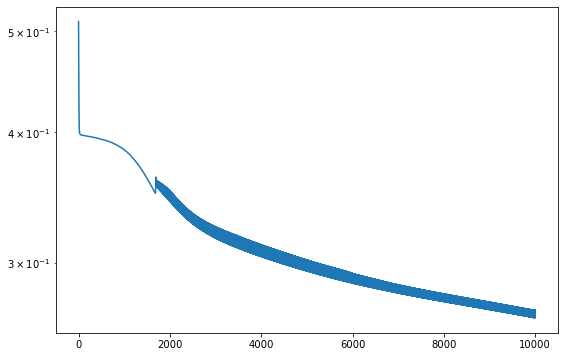

In [32]:
# Plot the error vs epochs
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

# My implementation

## Forwad feed once

In [33]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs_train, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# Error
print('Error:\n', BCE_loss(a[nLayers],outputs_train)/batchSize)

Outputs at each layer (including input layer):
  [array([[1.51793e+00, 1.27900e+01, 3.50000e+00, ..., 8.77000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51900e+00, 1.34900e+01, 3.48000e+00, ..., 9.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51832e+00, 1.33300e+01, 3.34000e+00, ..., 8.99000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.51764e+00, 1.29800e+01, 3.54000e+00, ..., 8.53000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51556e+00, 1.38700e+01, 0.00000e+00, ..., 9.41000e+00,
        8.10000e-01, 1.00000e-02],
       [1.52119e+00, 1.29700e+01, 3.30000e-01, ..., 1.12700e+01,
        0.00000e+00, 2.80000e-01]], dtype=float32), array([[9.7150385e-01, 1.2253037e-02, 2.4678427e-06, ..., 1.8262949e-02,
        2.7379610e-06, 4.4764366e-04],
       [9.6396279e-01, 1.1472684e-02, 3.2918181e-06, ..., 1.8059626e-02,
        3.8018802e-06, 4.7682170e-04],
       [9.6686387e-01, 1.1551168e-02, 2.8876684e-06, ..., 1.7302640e-02,
        3.6859744e-06, 4

Error:
 0.530571176663527


## Backpropagation

In [34]:
# Get the derivative of the output cost function wrt to the output vector of the output layer
# The input arguments should always be an array
dc_daL = BCE_loss_grad(a[nLayers], outputs_train)/batchSize
print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)

# Perform Back Propagation and get the derivatives wrt the weights and biases
derWeights, derBiases, weights, biases = back_propagation(z, a, activation_func_names, nLayers, batchSize, weightsOriginal, biasesOriginal, eeta, dc_daL)
print('Gradient of Cost (error function) wrt weights:\n',derWeights)
print('Gradient of Cost (error function) wrt biases:\n',derBiases)

Gradient of the error function wrt to the predicted output of the output layer
 [[-0.00409069  0.00104331  0.00116212  0.00114633  0.00140164  0.00128919]
 [-0.00408214  0.00104323  0.00116218  0.00114688  0.00140148  0.00128785]
 [ 0.00135309  0.00104322 -0.00810106  0.00114685  0.00140145  0.00128812]
 [-0.00409189  0.0010433   0.00116209  0.00114628  0.00140162  0.00128945]
 [ 0.00135529  0.00104331  0.00116157 -0.00893354  0.00140086  0.00128725]
 [ 0.00136032 -0.03938559  0.00116099  0.00114934  0.00139993  0.00128113]
 [-0.0040887   0.00104328  0.00116201  0.00114638  0.00140149  0.00128923]
 [-0.00409121  0.00104328  0.00116206  0.00114627  0.00140155  0.00128952]
 [ 0.00135759 -0.03955153  0.00116111  0.00114839  0.00140056  0.00128428]
 [ 0.00135193 -0.03926953  0.00116187  0.00114652  0.00140156  0.00128965]
 [ 0.00135211 -0.03928275  0.00116195  0.00114665  0.00140161  0.0012892 ]
 [-0.00409423  0.00104331  0.00116204  0.0011462   0.00140156  0.00128989]
 [-0.00408018  0.001

Gradient of Cost (error function) wrt weights:
 [array([[ 6.91348905e-05,  6.25933695e-04,  3.83110491e-05,
         9.24930137e-05,  3.29929660e-03,  2.47013450e-05,
         4.24537953e-04,  3.87131804e-05,  3.17274134e-06],
       [-8.00585913e-05, -6.89006003e-04, -2.06886587e-04,
        -5.82850225e-05, -3.83194699e-03, -1.87923561e-05,
        -4.62295924e-04,  5.39481562e-06, -3.93787877e-06],
       [-4.06272083e-09, -3.57803849e-08, -1.11109486e-08,
        -1.88279503e-09, -1.93169399e-07, -8.32272806e-10,
        -2.40231852e-08, -1.66961084e-10, -8.63740260e-11],
       [ 2.50783472e-07,  2.10278540e-06,  5.28945009e-07,
         2.08352063e-07,  1.19411079e-05,  1.37489977e-07,
         1.57582292e-06, -3.09734531e-08,  1.58462345e-08],
       [-1.64103585e-05, -1.31054127e-04,  4.58889030e-04,
        -1.87569793e-04, -7.78687245e-04, -9.43236664e-05,
        -2.93234887e-04, -3.12534867e-05, -8.25228926e-06],
       [ 3.98079783e-06,  3.34127180e-05,  9.17555735e-06,
  

## Gradient descent (update the weights and biases)

In [35]:
newWeights = [weightsOriginal[i] - eeta*derWeights[i] for i in range(nLayers)]
print('New Weights: ', newWeights)

newBiases = [biasesOriginal[i] - eeta*derBiases[i] for i in range(nLayers)]
# newBiases = biasesOriginal
print('New Biases: ', newBiases)

New Weights:  [array([[ 0.17558451, -0.17833231, -0.05403423,  0.15601835,  0.09201598,
         0.22546338, -0.15185013,  0.04990785,  0.18667233],
       [-0.05703899, -0.1345129 ,  0.17811866,  0.0807054 , -0.04027795,
         0.21247761, -0.05263177,  0.00518357,  0.12652414],
       [-0.19259831,  0.18534182,  0.21956877, -0.17220017, -0.2027035 ,
        -0.03406763, -0.08446065, -0.07968678, -0.05865441],
       [ 0.01413295,  0.00470805, -0.0280407 , -0.03601646,  0.14654894,
        -0.04019721, -0.08946323,  0.19050921, -0.09231812],
       [-0.00911453, -0.06611622,  0.08011424, -0.07719205, -0.00409373,
         0.13414943,  0.04746218, -0.02851232, -0.14844804],
       [-0.23223138, -0.23427062,  0.14894046, -0.13146223, -0.05148146,
         0.14248411,  0.04498518, -0.179436  , -0.21170281],
       [ 0.06391354, -0.10912387,  0.04377862, -0.02206779, -0.03401823,
        -0.07877541, -0.1338783 , -0.11058089,  0.06247423],
       [ 0.01546128, -0.04132026,  0.21007748, 

## Forward feed again and check the loss/error

In [36]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs_train, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# New Error
print('New Error:\n', BCE_loss(a[nLayers],outputs_train)/batchSize)

Outputs at each layer (including input layer):
  [array([[1.51793e+00, 1.27900e+01, 3.50000e+00, ..., 8.77000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51900e+00, 1.34900e+01, 3.48000e+00, ..., 9.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51832e+00, 1.33300e+01, 3.34000e+00, ..., 8.99000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.51764e+00, 1.29800e+01, 3.54000e+00, ..., 8.53000e+00,
        0.00000e+00, 0.00000e+00],
       [1.51556e+00, 1.38700e+01, 0.00000e+00, ..., 9.41000e+00,
        8.10000e-01, 1.00000e-02],
       [1.52119e+00, 1.29700e+01, 3.30000e-01, ..., 1.12700e+01,
        0.00000e+00, 2.80000e-01]], dtype=float32), array([[9.7150385e-01, 1.2253037e-02, 2.4678427e-06, ..., 1.8262949e-02,
        2.7379610e-06, 4.4764366e-04],
       [9.6396279e-01, 1.1472684e-02, 3.2918181e-06, ..., 1.8059626e-02,
        3.8018802e-06, 4.7682170e-04],
       [9.6686387e-01, 1.1551168e-02, 2.8876684e-06, ..., 1.7302640e-02,
        3.6859744e-06, 4

## ** With np.einsum (slightly Slower than opt_einsum expression reuse)**

In [37]:
%%time

# Run optimization
optWeights, optBiases, errorPlot = nn_optimize(inputs_train, outputs_train, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=BCE_loss, gradErrorFunc=BCE_loss_grad,miniterEpoch=1,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.530571176663527
CPU times: user 44.3 s, sys: 585 ms, total: 44.9 s
Wall time: 45 s


In [38]:
print(errorPlot)

[0.530571176663527, 0.510991267917218, 0.4952276122300312, 0.4817910020270681, 0.4699655175591457, 0.4594285480795393, 0.44999398373895433, 0.44155025574477, 0.4340540393714902, 0.42749535296082375, 0.42186294025738763, 0.4171246508927259, 0.4132211689400297, 0.41006865897369055, 0.4075667242848406, 0.4056085565924888, 0.4040905071866809, 0.40291916072691664, 0.4020151895746316, 0.40131434868043697, 0.4007664326786888, 0.4003332416075183, 0.39998620787947886, 0.3997041643022576, 0.3994715132775275, 0.39927674499750315, 0.39911133989209907, 0.3989689727065522, 0.39884490071182505, 0.39873558146385457, 0.3986383264893167, 0.39855110888101797, 0.3984723772254771, 0.39840094883458355, 0.39833589982989687, 0.39827650743243176, 0.3982221749487994, 0.39817240462362713, 0.39812676917797724, 0.39808487344641263, 0.3980463719342219, 0.3980109424927514, 0.3979782882121446, 0.39794812724276707, 0.39792021263942157, 0.3978943167205419, 0.3978702238618589, 0.3978477501826216, 0.39782673211658803, 0.

In [39]:
print(errorPlot)

[0.530571176663527, 0.510991267917218, 0.4952276122300312, 0.4817910020270681, 0.4699655175591457, 0.4594285480795393, 0.44999398373895433, 0.44155025574477, 0.4340540393714902, 0.42749535296082375, 0.42186294025738763, 0.4171246508927259, 0.4132211689400297, 0.41006865897369055, 0.4075667242848406, 0.4056085565924888, 0.4040905071866809, 0.40291916072691664, 0.4020151895746316, 0.40131434868043697, 0.4007664326786888, 0.4003332416075183, 0.39998620787947886, 0.3997041643022576, 0.3994715132775275, 0.39927674499750315, 0.39911133989209907, 0.3989689727065522, 0.39884490071182505, 0.39873558146385457, 0.3986383264893167, 0.39855110888101797, 0.3984723772254771, 0.39840094883458355, 0.39833589982989687, 0.39827650743243176, 0.3982221749487994, 0.39817240462362713, 0.39812676917797724, 0.39808487344641263, 0.3980463719342219, 0.3980109424927514, 0.3979782882121446, 0.39794812724276707, 0.39792021263942157, 0.3978943167205419, 0.3978702238618589, 0.3978477501826216, 0.39782673211658803, 0.

#### Test the quality of the weights by running a forward feed again

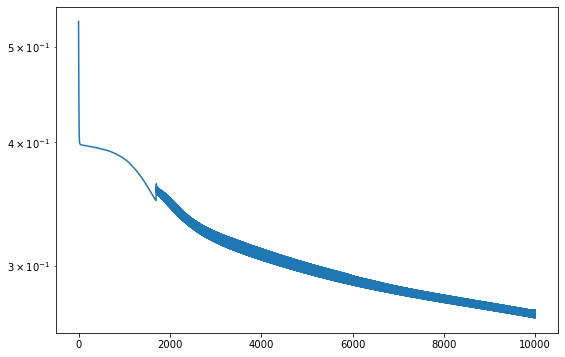

In [40]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [41]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', BCE_loss(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[ 1.76822484e-01, -1.68460220e-01, -4.69248071e-02,
         1.54716074e-01,  1.50916085e-01,  2.25275233e-01,
        -1.42709404e-01,  4.77187373e-02,  1.86671540e-01],
       [-3.80436666e-02, -6.14436269e-01,  1.26665354e+00,
        -2.16949597e-01,  5.56667000e-02,  8.10281157e-01,
         5.88538826e-01, -6.06413245e-01,  1.72778159e-01],
       [-1.92598313e-01,  1.85341820e-01,  2.19568774e-01,
        -1.72200173e-01, -2.02664807e-01, -3.40676308e-02,
        -8.44465122e-02, -7.96867758e-02, -5.86544126e-02],
       [ 1.40919797e-02,  4.43059672e-03, -2.81079188e-02,
        -3.60546485e-02,  1.44652233e-01, -4.02950868e-02,
        -8.97884667e-02,  1.90526724e-01, -9.23181176e-02],
       [-7.06071034e-04, -5.77453077e-01, -1.23473711e-03,
         2.72530586e-01,  6.19174689e-02,  7.24230647e-01,
         2.73149312e-01, -2.62333632e-01, -6.64009601e-02],
       [-2.32595161e-01, -2.37332702e-01,  1.48258328e-01,
        -1.31939009e-01, -6.88

New Average Error with optimized weights:
 0.3632084235737083
Input:  [[ 1.52101 13.64     4.49    ...  8.75     0.       0.     ]
 [ 1.51761 13.89     3.6     ...  7.83     0.       0.     ]
 [ 1.51618 13.53     3.55    ...  7.78     0.       0.     ]
 ...
 [ 1.52065 14.36     0.      ...  8.44     1.64     0.     ]
 [ 1.51651 14.38     0.      ...  8.48     1.57     0.     ]
 [ 1.51711 14.23     0.      ...  8.62     1.67     0.     ]]
Output:  [[7.03003883e-01 1.77027479e-01 1.12771474e-01 9.21300845e-04
  5.51468926e-03 7.61228439e-04]
 [5.36594272e-01 3.06215376e-01 1.30624533e-01 3.93376779e-03
  1.82452910e-02 4.38678218e-03]
 [5.13856292e-01 3.28831941e-01 1.28957570e-01 4.61864378e-03
  1.90514997e-02 4.68407618e-03]
 ...
 [4.93121752e-06 9.85879218e-04 2.31183822e-05 2.17574723e-02
  3.50189917e-02 9.42209601e-01]
 [5.44574368e-06 1.06178201e-03 2.52007067e-05 2.26533357e-02
  3.65510359e-02 9.39703166e-01]
 [5.72673071e-06 1.14392384e-03 2.64734681e-05 2.47071423e-02
  3.773

In [42]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
0.020693718
0.0002905752

Layer :  2
0.0003965199
0.00039167423

Layer :  3
0.0018980652
0.002136074


## ** NEW METHOD ** With opt_einsum expressions (It is faster than np.einsum but only slightly)

In [43]:
%%time
# Run optimization
optWeights, optBiases, errorPlot = nn_optimize_fast(inputs_train, outputs_train, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=BCE_loss, gradErrorFunc=BCE_loss_grad,miniterEpoch=100,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.530571176663527
CPU times: user 34.4 s, sys: 316 ms, total: 34.7 s
Wall time: 34.8 s


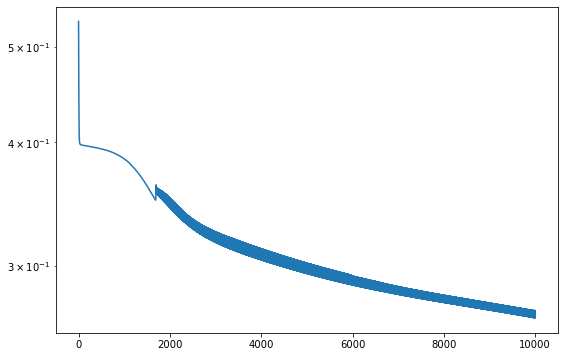

In [44]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

## Prediction on test set

In [69]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs_test, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', BCE_loss(a[nLayers],outputs_test)/batchSize)
print('Input: ',inputs_test)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs_test)

Optimized Weights:  [array([[ 1.76822439e-01, -1.68461323e-01, -4.69250679e-02,
         1.54716030e-01,  1.50909886e-01,  2.25275010e-01,
        -1.42709851e-01,  4.77186590e-02,  1.86671689e-01],
       [-3.81247178e-02, -6.15152121e-01,  1.26669025e+00,
        -2.17029884e-01,  5.17881997e-02,  8.10160577e-01,
         5.87863326e-01, -6.06287062e-01,  1.72774702e-01],
       [-1.92598313e-01,  1.85341820e-01,  2.19568774e-01,
        -1.72200173e-01, -2.02664912e-01, -3.40676308e-02,
        -8.44465122e-02, -7.96867758e-02, -5.86544126e-02],
       [ 1.40919602e-02,  4.43063071e-03, -2.81079169e-02,
        -3.60546410e-02,  1.44652620e-01, -4.02950868e-02,
        -8.97884071e-02,  1.90526694e-01, -9.23181176e-02],
       [-6.23028493e-04, -5.76812744e-01, -9.45925131e-04,
         2.72552222e-01,  6.59015924e-02,  7.24302351e-01,
         2.73644894e-01, -2.62388617e-01, -6.63905367e-02],
       [-2.32595116e-01, -2.37332508e-01,  1.48258522e-01,
        -1.31938815e-01, -6.88

In [72]:
# make probability predictions with the model
predictionsCrysx = a[nLayers]
print(predictionsCrysx) # Probabilities

predictions_max_int = (predictionsCrysx == predictionsCrysx.max(axis=1)[:,None]).astype(float)
print(predictions_max_int) # Maximum probability returned as 1

[[2.99622566e-01 5.30365586e-01 1.09979860e-01 1.68565586e-02
  3.33032385e-02 9.87223815e-03]
 [5.03022432e-01 3.46548200e-01 1.26565456e-01 4.25629038e-03
  1.66075230e-02 3.00007127e-03]
 [3.45901459e-01 4.82998252e-01 1.18337169e-01 1.25020724e-02
  3.21990959e-02 8.06188956e-03]
 [4.39480126e-01 4.18581516e-01 1.17623650e-01 6.37130346e-03
  1.51848188e-02 2.75851251e-03]
 [5.93883455e-01 2.64735967e-01 1.26129299e-01 2.14209477e-03
  1.13039734e-02 1.80519279e-03]
 [3.98639947e-01 4.46794182e-01 1.19233876e-01 8.65061861e-03
  2.21341196e-02 4.54735337e-03]
 [4.07734334e-01 4.56540197e-01 1.10849001e-01 7.74516305e-03
  1.46456594e-02 2.48562312e-03]
 [4.36203241e-01 4.20751244e-01 1.18003272e-01 6.51032105e-03
  1.55870570e-02 2.94481847e-03]
 [2.58659154e-01 5.21983385e-01 1.11840531e-01 2.24003606e-02
  6.00844435e-02 2.50321999e-02]
 [3.46587628e-01 4.79847968e-01 1.19543828e-01 1.24266436e-02
  3.24869677e-02 9.10699926e-03]
 [3.91797960e-01 4.43873405e-01 1.22602262e-01 9.1

In [73]:
# We need to use argmax as one hot encodings are not supported by confusion matrix
confusion_matrix(outputs_test.argmax(axis=1), predictions_max_int.argmax(axis=1))

array([[ 6,  7,  0,  0,  0,  0],
       [ 4, 18,  0,  2,  0,  0],
       [ 3,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  6]])

In [65]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
0.00024318695
1.997454e-06

Layer :  2
4.7698617e-05
3.7513673e-06

Layer :  3
5.054474e-05
7.197261e-06


### BCE testing

In [47]:
X = torch.tensor([[1,0],[1,0],[0,1],[0,1]],dtype=torch.float)
softmaxTorch = torch.nn.Softmax(dim=1)


bce_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss()
ce_loss= torch.nn.CrossEntropyLoss()

# My implementation of Softmax
pred = Softmax(X.cpu().detach().numpy())
print(pred)
# PyTorch implementation of Softmax
pred = softmaxTorch(X)
print(pred)


print(bce_loss(X,X)) # tensor(0.)
print(bce_loss(pred,X)) # tensor(0.3133)
print(bce_loss(pred,pred)) # tensor(0.5822)

print(ce_loss(X,torch.argmax(X,dim=1))) # tensor(0.3133)

# My implementation of cross entropy loss
# Note these will be Nsamples*PyTorch results as I don't return the average right away
print(binary_cross_entropy(X.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])
print(binary_cross_entropy(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])
print(binary_cross_entropy(pred.cpu().detach().numpy(),pred.cpu().detach().numpy())/X.shape[0])

print(binary_cross_entropy(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])
print(cross_entropy_grad(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])
print(errorFuncGrad(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0])

predX = torch.tensor(pred,dtype=torch.float,requires_grad=True)
loss = bce_loss(predX,X)
# loss = ce_loss(predX,torch.argmax(X,dim=1))
# loss = mse_loss(predX,X)
loss.backward()
print('gradient',predX.grad)
print(torch.autograd.grad(bce_loss(predX,X),predX))

%timeit binary_cross_entropy(pred.cpu().detach().numpy(),pred.cpu().detach().numpy())
%timeit binary_cross_entropy_grad(pred.cpu().detach().numpy(),X.cpu().detach().numpy())
%timeit bce_loss(predX,X)

%timeit softmaxTorch(X)
%timeit Softmax(X.cpu().detach().numpy())

%timeit cross_entropy(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0]
%timeit cross_entropy_grad(pred.cpu().detach().numpy(),X.cpu().detach().numpy())/X.shape[0]

[[0.7310586  0.26894143]
 [0.7310586  0.26894143]
 [0.26894143 0.7310586 ]
 [0.26894143 0.7310586 ]]
tensor([[0.7311, 0.2689],
        [0.7311, 0.2689],
        [0.2689, 0.7311],
        [0.2689, 0.7311]])
tensor(0.)
tensor(0.3133)
tensor(0.5822)
tensor(0.3133)
-4.991562718714704e-13
0.3132616819994708
0.5822031048526861
0.3132616819994708
[[-0.34196985 -0.        ]
 [-0.34196985 -0.        ]
 [-0.         -0.34196985]
 [-0.         -0.34196985]]
[[-0.06723535  0.06723536]
 [-0.06723535  0.06723536]
 [ 0.06723536 -0.06723535]
 [ 0.06723536 -0.06723535]]
gradient tensor([[-0.1710,  0.1710],
        [-0.1710,  0.1710],
        [ 0.1710, -0.1710],
        [ 0.1710, -0.1710]])
(tensor([[-0.1710,  0.1710],
        [-0.1710,  0.1710],
        [ 0.1710, -0.1710],
        [ 0.1710, -0.1710]]),)


/Users/admin/opt/anaconda3/envs/performance/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


151 µs ± 2.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
7.24 µs ± 20.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
41.1 µs ± 147 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
The slowest run took 6.98 times longer than the fastest. This could mean that an intermediate result is being cached.
14.2 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
25.9 µs ± 5.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
370 µs ± 84.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.1 µs ± 7.59 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### ReLU testing

In [48]:
device = 'cpu'

X = torch.randn((10,3),requires_grad=True)

actFunc = torch.nn.ReLU()
# actFunc = torch.nn.Sigmoid()
activatedOutputs = actFunc(X)
print(activatedOutputs)
print(ReLU(X.cpu().detach().numpy()))
# print(Sigmoid(X.cpu().detach().numpy()))


gradientsTorch = torch.autograd.grad(outputs=activatedOutputs, inputs=X,
                          grad_outputs=torch.ones(activatedOutputs.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]

print(gradientsTorch)

# gradientsCrysx = Sigmoid_grad(X.cpu().detach().numpy())
gradientsCrysx = ReLU_grad(X.cpu().detach().numpy())
print(gradientsCrysx)

tensor([[0.0000, 0.0000, 0.2447],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.1685, 0.4653],
        [0.6296, 1.3738, 1.2811],
        [0.0754, 0.1001, 0.0000],
        [0.2178, 1.0801, 1.1591],
        [0.0000, 0.0099, 0.1434],
        [0.0000, 0.0000, 0.6450],
        [0.0000, 0.8453, 0.0000],
        [0.9374, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)
[[0.         0.         0.2446689 ]
 [0.         0.         0.        ]
 [0.         0.16853148 0.46527004]
 [0.6296311  1.37381434 1.28109086]
 [0.07541627 0.10005862 0.        ]
 [0.21781965 1.08009934 1.15911269]
 [0.         0.00993879 0.14344202]
 [0.         0.         0.64502358]
 [0.         0.84529078 0.        ]
 [0.93739253 0.         0.        ]]
tensor([[0., 0., 1.],
        [0., 0., 0.],
        [0., 1., 1.],
        [1., 1., 1.],
        [1., 1., 0.],
        [1., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]], grad_fn=<ThresholdBackwardBackward>)
[[0. 0. 1.]
 [0

# PyTorch

In [49]:
### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

## Generate the network programatically

## Method 1

In [50]:
Layers = []
# Input layer
Layers.append(torch.nn.Linear(nInputs, neurons_per_layer[0]))
Layers.append(torch.nn.Sigmoid())

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Layers.append(torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Layers.append(torch.nn.Sigmoid())
    # Output layer
    Layers.append(torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Layers.append(torch.nn.Sigmoid())

In [51]:
Network = torch.nn.Sequential(*Layers)

In [52]:
print(Network)

Sequential(
  (0): Linear(in_features=9, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=100, out_features=6, bias=True)
  (5): Sigmoid()
)


## Method 2 (Suitable for us to modify weights for each layer to be same as keras and my implementation)

In [53]:
Network = torch.nn.Sequential()
 
# Input layer -> 1st hidden layer
Network.add_module(str(0),torch.nn.Linear(nInputs, neurons_per_layer[0]))
# Activation function after first hidden layer
Network.add_module('act0',act_func_dict_PyTorch[activation_func_names[0]])

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Network.add_module(str(i),torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Network.add_module('act'+str(i),act_func_dict_PyTorch[activation_func_names[i]])
        
    # Output layer
    Network.add_module(str(nLayers-1),torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Network.add_module('act'+str(nLayers-1),act_func_dict_PyTorch[activation_func_names[nLayers-1]])

In [54]:
# torch.nn.init.constant_(Network.weight, 2.0)
Network.to(device=device)

Sequential(
  (0): Linear(in_features=9, out_features=100, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=100, out_features=100, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=100, out_features=6, bias=True)
  (act2): Softmax(dim=1)
)

## initial weights and biases generated by Pytorch

In [55]:
print(Network[0].weight)
print(Network[0].bias)

Parameter containing:
tensor([[ 0.2559, -0.1689,  0.1911,  0.0636, -0.2677, -0.1262,  0.0155,  0.2122,
         -0.1236],
        [ 0.0499, -0.1719, -0.1638,  0.2332,  0.0123, -0.2413,  0.0557, -0.0883,
         -0.2062],
        [-0.2438, -0.0068, -0.1496,  0.3000,  0.0355, -0.3036, -0.1056, -0.2962,
          0.3102],
        [ 0.1495, -0.1398, -0.1324,  0.1350, -0.2597,  0.1674,  0.1949,  0.0957,
          0.0500],
        [-0.1633, -0.2176, -0.0889, -0.1475,  0.1718,  0.2260,  0.0023,  0.2814,
         -0.0167],
        [-0.1277,  0.2388, -0.2862, -0.2869,  0.1998,  0.2668,  0.0040,  0.1368,
          0.2644],
        [ 0.2359,  0.3071,  0.1915, -0.3140,  0.1758, -0.0584, -0.1643,  0.0693,
         -0.1325],
        [-0.0062, -0.3266, -0.0693, -0.0878, -0.0797,  0.0317, -0.1882,  0.3149,
          0.0746],
        [-0.1566,  0.3082,  0.2888, -0.1377,  0.1580,  0.0343, -0.1685, -0.1904,
          0.0836],
        [-0.2748, -0.2971,  0.0087, -0.0905,  0.3146,  0.0310, -0.1564,  0.280

## Change them to be the same as others

## **IMPORTANT NOTE**: The returned tensor and the original array share the same memory. So any changes to the tensor change the array as well.

Reference: https://pytorch.org/docs/stable/generated/torch.from_numpy.html



In [56]:
for i in range(nLayers):
    # Weights
#     Network._modules[str(i)].weight.data = torch.from_numpy(weightsOriginal[i]).to(dtype=torch.float32)
    Network._modules[str(i)].weight.data = torch.tensor(weightsOriginal[i]).to(dtype=torch.float32)
    # Biases
#     Network._modules[str(i)].bias.data = torch.from_numpy(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32
    Network._modules[str(i)].bias.data = torch.tensor(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32

In [57]:
for i in range(nLayers):
    # Weights
    print('Weights:\n')
    print(Network._modules[str(i)].weight.data)
    # Biases
    print('Biases:\n')
    print(Network._modules[str(i)].bias.data)

Weights:

tensor([[ 1.7559e-01, -1.7827e-01, -5.4030e-02,  1.5603e-01,  9.2346e-02,
          2.2547e-01, -1.5181e-01,  4.9912e-02,  1.8667e-01],
        [-5.7047e-02, -1.3458e-01,  1.7810e-01,  8.0700e-02, -4.0661e-02,
          2.1248e-01, -5.2678e-02,  5.1841e-03,  1.2652e-01],
        [-1.9260e-01,  1.8534e-01,  2.1957e-01, -1.7220e-01, -2.0270e-01,
         -3.4068e-02, -8.4461e-02, -7.9687e-02, -5.8654e-02],
        [ 1.4133e-02,  4.7083e-03, -2.8041e-02, -3.6016e-02,  1.4655e-01,
         -4.0197e-02, -8.9463e-02,  1.9051e-01, -9.2318e-02],
        [-9.1162e-03, -6.6129e-02,  8.0160e-02, -7.7211e-02, -4.1716e-03,
          1.3414e-01,  4.7433e-02, -2.8515e-02, -1.4845e-01],
        [-2.3223e-01, -2.3427e-01,  1.4894e-01, -1.3146e-01, -5.1462e-02,
          1.4248e-01,  4.4988e-02, -1.7944e-01, -2.1170e-01],
        [ 6.3912e-02, -1.0914e-01,  4.3775e-02, -2.2069e-02, -3.4092e-02,
         -7.8776e-02, -1.3389e-01, -1.1058e-01,  6.2474e-02],
        [ 1.5462e-02, -4.1315e-02,  2.

In [58]:
### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
# crit = torch.nn.MSELoss()
crit = torch.nn.BCELoss()
# crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(Network.parameters(), lr=eeta)

Sequential(
  (0): Linear(in_features=9, out_features=100, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=100, out_features=100, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=100, out_features=6, bias=True)
  (act2): Softmax(dim=1)
)
11706 trainable parameters


In [59]:
inputsTorch = torch.from_numpy(inputs_train)
inputsTorch = inputsTorch.to(dtype=torch.float32) # Convert to float32
labels = torch.from_numpy(outputs_train)
labels = labels.to(dtype=torch.float32) # Convert to float32

In [60]:
print(inputsTorch)
print(labels)

tensor([[1.5179e+00, 1.2790e+01, 3.5000e+00,  ..., 8.7700e+00, 0.0000e+00,
         0.0000e+00],
        [1.5190e+00, 1.3490e+01, 3.4800e+00,  ..., 9.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.5183e+00, 1.3330e+01, 3.3400e+00,  ..., 8.9900e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.5176e+00, 1.2980e+01, 3.5400e+00,  ..., 8.5300e+00, 0.0000e+00,
         0.0000e+00],
        [1.5156e+00, 1.3870e+01, 0.0000e+00,  ..., 9.4100e+00, 8.1000e-01,
         1.0000e-02],
        [1.5212e+00, 1.2970e+01, 3.3000e-01,  ..., 1.1270e+01, 0.0000e+00,
         2.8000e-01]])
tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0

In [61]:
%%time
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, nEpochs+1)
errorPlot = []
nBatches = int(inputsTorch.shape[0]/batchSize)
print(nBatches)
### Train the model
for e in tqdm(epochs,miniters=100):
    tr_loss = 0.
    samples = 0
    ### Loop over batches
#     for iBatch in tqdm(range(nBatches),leave=False,miniters=100):
    for iBatch in range(nBatches):
        offset = iBatch*batchSize
        inputsBatch = inputsTorch[offset:offset + batchSize,:]# Input vector
#            print(x.shape)
        labelsBatch = labels[offset:offset + batchSize,:] # Expected output
#         print(inputsBatch.shape)
        
        opt.zero_grad() # zero gradient values
        inputsBatch = inputsBatch.to(device=device) # move input and label tensors to the device with the model
        labelsBatch = labelsBatch.to(device=device)
        outputsTorch = Network(inputsBatch) # compute model outputs
        loss = crit(outputsTorch, labelsBatch) # compute batch loss
        loss.backward() # back-propagate the gradients
        opt.step() # update the model weights
        tr_loss += loss.clone().cpu().item()*len(inputsBatch) # add the batch loss to the running loss
        samples += len(inputsBatch) # update the number of processed samples
    tr_loss /= samples # compute training loss
    errorPlot.append(tr_loss)
    print(e, tr_loss)

1


  0%|          | 0/10000 [00:00<?, ?it/s]

1 0.5305711627006531
2 0.5109912753105164
3 0.4952276349067688
4 0.4817909896373749
5 0.46996554732322693
6 0.4594285488128662
7 0.4499939978122711
8 0.44155025482177734
9 0.4340539872646332
10 0.42749539017677307
11 0.42186295986175537
12 0.4171246588230133
13 0.41322118043899536
14 0.41006866097450256
15 0.40756672620773315
16 0.40560853481292725
17 0.4040905237197876
18 0.4029191732406616
19 0.40201517939567566
20 0.4013143479824066
21 0.40076640248298645
22 0.4003332555294037
23 0.399986207485199
24 0.39970412850379944
25 0.3994714915752411
26 0.3992767333984375
27 0.3991113603115082
28 0.39896899461746216
29 0.3988448977470398
30 0.39873558282852173
31 0.3986383080482483
32 0.3985511362552643
33 0.3984723687171936
34 0.3984009325504303
35 0.39833590388298035
36 0.39827653765678406
37 0.3982221484184265
38 0.39817240834236145
39 0.3981267511844635
40 0.3980848789215088
41 0.3980463445186615
42 0.3980109393596649
43 0.397978276014328
44 0.39794811606407166
45 0.39792025089263916
46 

360 0.39541029930114746
361 0.39540183544158936
362 0.39539334177970886
363 0.395384818315506
364 0.39537617564201355
365 0.3953675627708435
366 0.3953588604927063
367 0.3953501284122467
368 0.39534133672714233
369 0.3953325152397156
370 0.39532366394996643
371 0.39531469345092773
372 0.3953056335449219
373 0.39529654383659363
374 0.3952874541282654
375 0.3952782452106476
376 0.3952690064907074
377 0.39525964856147766
378 0.39525026082992554
379 0.39524078369140625
380 0.3952312767505646
381 0.39522168040275574
382 0.39521196484565735
383 0.3952022194862366
384 0.395192414522171
385 0.3951825201511383
386 0.3951725363731384
387 0.3951624035835266
388 0.3951523005962372
389 0.3951421082019806
390 0.39513176679611206
391 0.39512142539024353
392 0.3951110243797302
393 0.39510053396224976
394 0.3950899541378021
395 0.3950793147087097
396 0.39506861567497253
397 0.39505788683891296
398 0.3950470983982086
399 0.3950362801551819
400 0.3950254023075104
401 0.3950144946575165
402 0.395003587007

713 0.39128679037094116
714 0.3912706971168518
715 0.39125457406044006
716 0.3912384808063507
717 0.3912222683429718
718 0.3912060856819153
719 0.3911898136138916
720 0.3911735415458679
721 0.39115720987319946
722 0.3911408483982086
723 0.3911244869232178
724 0.39110806584358215
725 0.39109164476394653
726 0.39107513427734375
727 0.3910585641860962
728 0.3910420835018158
729 0.39102548360824585
730 0.39100882411003113
731 0.390992134809494
732 0.3909754455089569
733 0.390958696603775
734 0.39094194769859314
735 0.3909251391887665
736 0.39090830087661743
737 0.3908914029598236
738 0.3908745348453522
739 0.3908575475215912
740 0.3908405601978302
741 0.39082351326942444
742 0.3908064663410187
743 0.39078930020332336
744 0.3907721936702728
745 0.3907549977302551
746 0.39073777198791504
747 0.39072051644325256
748 0.3907032608985901
749 0.39068588614463806
750 0.39066851139068604
751 0.39065107703208923
752 0.39063361287117004
753 0.3906160891056061
754 0.3905985653400421
755 0.390581011772

1076 0.3825521469116211
1077 0.3825176954269409
1078 0.3824831545352936
1079 0.3824485242366791
1080 0.3824138045310974
1081 0.38237905502319336
1082 0.38234415650367737
1083 0.3823091983795166
1084 0.38227415084838867
1085 0.38223904371261597
1086 0.3822038173675537
1087 0.3821685016155243
1088 0.3821331262588501
1089 0.38209763169288635
1090 0.38206198811531067
1091 0.3820263743400574
1092 0.38199058175086975
1093 0.38195472955703735
1094 0.3819187581539154
1095 0.3818826973438263
1096 0.38184654712677
1097 0.3818103075027466
1098 0.3817739188671112
1099 0.38173750042915344
1100 0.3817008435726166
1101 0.3816641867160797
1102 0.3816273808479309
1103 0.38159042596817017
1104 0.38155341148376465
1105 0.3815162479877472
1106 0.3814789652824402
1107 0.38144156336784363
1108 0.38140395283699036
1109 0.3813662528991699
1110 0.38132837414741516
1111 0.38129037618637085
1112 0.3812521994113922
1113 0.38121387362480164
1114 0.38117530941963196
1115 0.38113656640052795
1116 0.381097674369812
1

1422 0.3661293685436249
1423 0.3660708963871002
1424 0.366012305021286
1425 0.3659537136554718
1426 0.36589503288269043
1427 0.3658362925052643
1428 0.36577752232551575
1429 0.36571869254112244
1430 0.36565977334976196
1431 0.3656007945537567
1432 0.36554181575775146
1433 0.36548274755477905
1434 0.3654235899448395
1435 0.3653643727302551
1436 0.3653051555156708
1437 0.36524587869644165
1438 0.365186482667923
1439 0.3651270866394043
1440 0.36506763100624084
1441 0.36500808596611023
1442 0.3649485111236572
1443 0.36488890647888184
1444 0.3648292124271393
1445 0.36476948857307434
1446 0.36470964550971985
1447 0.36464983224868774
1448 0.3645899295806885
1449 0.36452996730804443
1450 0.364469975233078
1451 0.3644098937511444
1452 0.3643497824668884
1453 0.36428964138031006
1454 0.3642294108867645
1455 0.36416909098625183
1456 0.3641088008880615
1457 0.36404842138290405
1458 0.3639879822731018
1459 0.3639274537563324
1460 0.36386698484420776
1461 0.3638063669204712
1462 0.3637457489967346
1

1777 0.35223692655563354
1778 0.3580557107925415
1779 0.35215795040130615
1780 0.35800862312316895
1781 0.3520791232585907
1782 0.357961505651474
1783 0.35200035572052
1784 0.3579142391681671
1785 0.35192161798477173
1786 0.35786688327789307
1787 0.3518429398536682
1788 0.3578193485736847
1789 0.35176435112953186
1790 0.35777172446250916
1791 0.3516858220100403
1792 0.3577239215373993
1793 0.3516072630882263
1794 0.3576759099960327
1795 0.3515287935733795
1796 0.3576277792453766
1797 0.3514503538608551
1798 0.35757943987846375
1799 0.3513719439506531
1800 0.3575308918952942
1801 0.3512935936450958
1802 0.3574821650981903
1803 0.3512152433395386
1804 0.3574332892894745
1805 0.3511369526386261
1806 0.35738417506217957
1807 0.3510587513446808
1808 0.35733485221862793
1809 0.3509804904460907
1810 0.3572852611541748
1811 0.3509022891521454
1812 0.35723549127578735
1813 0.3508240282535553
1814 0.3571854829788208
1815 0.35074588656425476
1816 0.35713526606559753
1817 0.3506677448749542
1818 0

2128 0.34655168652534485
2129 0.33868128061294556
2130 0.3464720547199249
2131 0.33860695362091064
2132 0.3463926911354065
2133 0.33853280544281006
2134 0.3463134467601776
2135 0.3384588062763214
2136 0.34623435139656067
2137 0.3383848965167999
2138 0.3461554944515228
2139 0.33831119537353516
2140 0.3460767865180969
2141 0.33823758363723755
2142 0.34599825739860535
2143 0.3381641209125519
2144 0.3459198772907257
2145 0.33809080719947815
2146 0.34584176540374756
2147 0.33801767230033875
2148 0.3457637429237366
2149 0.3379446268081665
2150 0.3456859290599823
2151 0.3378716707229614
2152 0.34560832381248474
2153 0.3377988934516907
2154 0.34553083777427673
2155 0.33772632479667664
2156 0.34545353055000305
2157 0.3376538157463074
2158 0.3453763723373413
2159 0.33758142590522766
2160 0.3452994227409363
2161 0.3375092148780823
2162 0.3452225923538208
2163 0.33743709325790405
2164 0.34514597058296204
2165 0.33736515045166016
2166 0.3450694680213928
2167 0.3372932970523834
2168 0.34499314427375

2466 0.3352814018726349
2467 0.32789283990859985
2468 0.3352275490760803
2469 0.32783910632133484
2470 0.33517393469810486
2471 0.32778555154800415
2472 0.33512040972709656
2473 0.32773202657699585
2474 0.3350670039653778
2475 0.3276786804199219
2476 0.3350137770175934
2477 0.32762545347213745
2478 0.3349606990814209
2479 0.3275722861289978
2480 0.33490774035453796
2481 0.3275192975997925
2482 0.33485496044158936
2483 0.32746636867523193
2484 0.3348022699356079
2485 0.3274135887622833
2486 0.3347497880458832
2487 0.3273608684539795
2488 0.3346974551677704
2489 0.32730832695961
2490 0.33464518189430237
2491 0.32725584506988525
2492 0.33459311723709106
2493 0.3272034823894501
2494 0.3345411717891693
2495 0.32715123891830444
2496 0.3344893753528595
2497 0.327099084854126
2498 0.33443766832351685
2499 0.32704707980155945
2500 0.3343861997127533
2501 0.3269951641559601
2502 0.3343348205089569
2503 0.32694336771965027
2504 0.33428359031677246
2505 0.32689169049263
2506 0.33423247933387756
25

2803 0.3202618360519409
2804 0.32789286971092224
2805 0.320223331451416
2806 0.3278569281101227
2807 0.32018494606018066
2808 0.3278210461139679
2809 0.3201466500759125
2810 0.3277852237224579
2811 0.3201083242893219
2812 0.32774943113327026
2813 0.32007017731666565
2814 0.3277137279510498
2815 0.3200320303440094
2816 0.3276780843734741
2817 0.3199940025806427
2818 0.3276425302028656
2819 0.3199560046195984
2820 0.32760706543922424
2821 0.31991806626319885
2822 0.3275716006755829
2823 0.3198801875114441
2824 0.3275362253189087
2825 0.3198423981666565
2826 0.3275009095668793
2827 0.3198046088218689
2828 0.32746565341949463
2829 0.31976696848869324
2830 0.32743045687675476
2831 0.31972938776016235
2832 0.32739534974098206
2833 0.31969186663627625
2834 0.32736027240753174
2835 0.3196543753147125
2836 0.3273252844810486
2837 0.3196169435977936
2838 0.3272903263568878
2839 0.3195795714855194
2840 0.3272554278373718
2841 0.3195422887802124
2842 0.327220618724823
2843 0.31950509548187256
2844

3140 0.32257750630378723
3141 0.3145618140697479
3142 0.32254937291145325
3143 0.314532071352005
3144 0.32252126932144165
3145 0.31450244784355164
3146 0.32249322533607483
3147 0.3144727647304535
3148 0.3224652111530304
3149 0.3144431710243225
3150 0.32243725657463074
3151 0.31441357731819153
3152 0.3224093019962311
3153 0.3143840432167053
3154 0.3223813772201538
3155 0.3143545687198639
3156 0.3223535418510437
3157 0.31432512402534485
3158 0.3223257064819336
3159 0.3142957091331482
3160 0.3222978711128235
3161 0.3142663240432739
3162 0.32227012515068054
3163 0.31423699855804443
3164 0.3222423791885376
3165 0.31420770287513733
3166 0.32221466302871704
3167 0.314178466796875
3168 0.32218700647354126
3169 0.31414923071861267
3170 0.3221593499183655
3171 0.31412002444267273
3172 0.32213178277015686
3173 0.3140908479690552
3174 0.32210418581962585
3175 0.3140617609024048
3176 0.322076678276062
3177 0.3140326738357544
3178 0.32204917073249817
3179 0.3140036463737488
3180 0.3220216929912567
3

3479 0.3100099265575409
3480 0.3182380497455597
3481 0.30998486280441284
3482 0.3182126581668854
3483 0.3099597692489624
3484 0.3181872069835663
3485 0.3099347949028015
3486 0.3181617259979248
3487 0.30990973114967346
3488 0.3181363046169281
3489 0.3098846971988678
3490 0.31811079382896423
3491 0.3098597228527069
3492 0.31808534264564514
3493 0.309834748506546
3494 0.3180597722530365
3495 0.30980977416038513
3496 0.318034291267395
3497 0.309784859418869
3498 0.3180088400840759
3499 0.3097599446773529
3500 0.3179832994937897
3501 0.3097350001335144
3502 0.3179577887058258
3503 0.3097100853919983
3504 0.31793224811553955
3505 0.30968520045280457
3506 0.3179067373275757
3507 0.3096603453159332
3508 0.31788119673728943
3509 0.3096354901790619
3510 0.31785568594932556
3511 0.3096106946468353
3512 0.3178301751613617
3513 0.309585839509964
3514 0.3178046643733978
3515 0.3095610737800598
3516 0.3177791237831116
3517 0.30953630805015564
3518 0.3177536725997925
3519 0.3095115125179291
3520 0.317

3823 0.30596908926963806
3824 0.31402987241744995
3825 0.3059469759464264
3826 0.314006507396698
3827 0.3059248924255371
3828 0.31398311257362366
3829 0.3059028089046478
3830 0.3139597773551941
3831 0.30588075518608093
3832 0.3139364719390869
3833 0.30585870146751404
3834 0.31391316652297974
3835 0.30583667755126953
3836 0.31388983130455017
3837 0.3058146834373474
3838 0.3138664960861206
3839 0.3057926893234253
3840 0.3138432204723358
3841 0.3057706952095032
3842 0.3138199746608734
3843 0.30574873089790344
3844 0.313796728849411
3845 0.3057267367839813
3846 0.31377342343330383
3847 0.3057047724723816
3848 0.31375017762184143
3849 0.30568286776542664
3850 0.31372690200805664
3851 0.3056609034538269
3852 0.3137036859989166
3853 0.30563899874687195
3854 0.3136804699897766
3855 0.3056170642375946
3856 0.3136572539806366
3857 0.30559518933296204
3858 0.3136340081691742
3859 0.3055732846260071
3860 0.31361085176467896
3861 0.3055514693260193
3862 0.31358763575553894
3863 0.3055296242237091
3

4168 0.31014421582221985
4169 0.30231159925460815
4170 0.31012240052223206
4171 0.3022913336753845
4172 0.3101005554199219
4173 0.3022710084915161
4174 0.3100787401199341
4175 0.3022507131099701
4176 0.3100569546222687
4177 0.30223047733306885
4178 0.31003516912460327
4179 0.3022101819515228
4180 0.31001344323158264
4181 0.3021899461746216
4182 0.30999159812927246
4183 0.30216965079307556
4184 0.30996987223625183
4185 0.3021494448184967
4186 0.3099480867385864
4187 0.30212920904159546
4188 0.3099263906478882
4189 0.3021089732646942
4190 0.30990463495254517
4191 0.30208873748779297
4192 0.30988290905952454
4193 0.3020685315132141
4194 0.3098611831665039
4195 0.30204835534095764
4196 0.30983948707580566
4197 0.30202817916870117
4198 0.3098177909851074
4199 0.3020079731941223
4200 0.3097960948944092
4201 0.30198776721954346
4202 0.30977436900138855
4203 0.30196765065193176
4204 0.3097527027130127
4205 0.3019475042819977
4206 0.3097310960292816
4207 0.3019273579120636
4208 0.30970937013626

4518 0.30644676089286804
4519 0.29888007044792175
4520 0.3064262270927429
4521 0.2988611161708832
4522 0.3064057230949402
4523 0.2988421320915222
4524 0.30638518929481506
4525 0.2988232374191284
4526 0.30636465549468994
4527 0.29880428314208984
4528 0.30634424090385437
4529 0.29878535866737366
4530 0.30632367730140686
4531 0.29876643419265747
4532 0.3063032329082489
4533 0.2987474799156189
4534 0.3062826991081238
4535 0.2987286150455475
4536 0.30626222491264343
4537 0.2987096905708313
4538 0.3062417507171631
4539 0.2986907958984375
4540 0.30622127652168274
4541 0.2986718714237213
4542 0.30620086193084717
4543 0.2986530065536499
4544 0.3061804175376892
4545 0.2986341416835785
4546 0.30615994334220886
4547 0.2986152768135071
4548 0.3061394989490509
4549 0.29859641194343567
4550 0.30611908435821533
4551 0.29857757687568665
4552 0.30609869956970215
4553 0.2985587418079376
4554 0.3060782551765442
4555 0.2985398769378662
4556 0.30605781078338623
4557 0.2985210716724396
4558 0.306037366390228

4854 0.3030938506126404
4855 0.2957950830459595
4856 0.3030744194984436
4857 0.295777291059494
4858 0.303055077791214
4859 0.29575952887535095
4860 0.30303576588630676
4861 0.2957417964935303
4862 0.30301639437675476
4863 0.2957240641117096
4864 0.30299702286720276
4865 0.29570630192756653
4866 0.30297768115997314
4867 0.29568859934806824
4868 0.3029583692550659
4869 0.29567086696624756
4870 0.3029390275478363
4871 0.2956531047821045
4872 0.3029197156429291
4873 0.295635461807251
4874 0.30290040373802185
4875 0.2956177890300751
4876 0.30288106203079224
4877 0.2956000566482544
4878 0.3028617799282074
4879 0.2955823838710785
4880 0.30284252762794495
4881 0.2955647110939026
4882 0.30282318592071533
4883 0.2955470085144043
4884 0.30280396342277527
4885 0.2955293655395508
4886 0.3027847111225128
4887 0.29551172256469727
4888 0.302765429019928
4889 0.29549410939216614
4890 0.30274614691734314
4891 0.29547640681266785
4892 0.3027269244194031
4893 0.2954587936401367
4894 0.3027076721191406
489

5198 0.29987242817878723
5199 0.29284578561782837
5200 0.2998543977737427
5201 0.2928292155265808
5202 0.29983630776405334
5203 0.29281267523765564
5204 0.2998182773590088
5205 0.29279622435569763
5206 0.29980024695396423
5207 0.29277968406677246
5208 0.29978224635124207
5209 0.29276320338249207
5210 0.2997641861438751
5211 0.2927466928958893
5212 0.29974618554115295
5213 0.2927302122116089
5214 0.2997281849384308
5215 0.2927137613296509
5216 0.29971015453338623
5217 0.2926972806453705
5218 0.2996922433376312
5219 0.2926808297634125
5220 0.29967421293258667
5221 0.2926643490791321
5222 0.2996562421321869
5223 0.29264795780181885
5224 0.2996382713317871
5225 0.29263147711753845
5226 0.2996203303337097
5227 0.29261505603790283
5228 0.29960235953330994
5229 0.2925986647605896
5230 0.29958441853523254
5231 0.2925822138786316
5232 0.29956650733947754
5233 0.29256582260131836
5234 0.29954853653907776
5235 0.29254937171936035
5236 0.29953065514564514
5237 0.2925330102443695
5238 0.29951271414

5547 0.29007166624069214
5548 0.29683810472488403
5549 0.2900563180446625
5550 0.29682162404060364
5551 0.2900409400463104
5552 0.29680511355400085
5553 0.29002565145492554
5554 0.29678869247436523
5555 0.29001033306121826
5556 0.2967722415924072
5557 0.289995014667511
5558 0.29675576090812683
5559 0.2899796962738037
5560 0.2967393100261688
5561 0.2899644374847412
5562 0.2967228889465332
5563 0.28994911909103394
5564 0.2967064082622528
5565 0.28993386030197144
5566 0.2966899573802948
5567 0.2899186313152313
5568 0.2966735363006592
5569 0.2899033725261688
5570 0.29665708541870117
5571 0.2898881137371063
5572 0.29664066433906555
5573 0.2898728847503662
5574 0.29662424325942993
5575 0.2898576557636261
5576 0.2966078221797943
5577 0.2898423969745636
5578 0.2965913712978363
5579 0.2898271679878235
5580 0.2965749502182007
5581 0.28981199860572815
5582 0.29655852913856506
5583 0.28979676961898804
5584 0.29654207825660706
5585 0.2897816002368927
5586 0.2965256869792938
5587 0.28976643085479736

5887 0.2875779867172241
5888 0.29401659965515137
5889 0.2875642776489258
5890 0.2939993143081665
5891 0.28755059838294983
5892 0.2939819395542145
5893 0.2875369191169739
5894 0.2939645051956177
5895 0.28752321004867554
5896 0.2939469814300537
5897 0.287509560585022
5898 0.29392942786216736
5899 0.2874959111213684
5900 0.29391178488731384
5901 0.28748223185539246
5902 0.29389405250549316
5903 0.2874685823917389
5904 0.29387620091438293
5905 0.28745490312576294
5906 0.2938583195209503
5907 0.28744128346443176
5908 0.2938402593135834
5909 0.2874276340007782
5910 0.29382216930389404
5911 0.28741398453712463
5912 0.29380396008491516
5913 0.28740039467811584
5914 0.2937856614589691
5915 0.28738677501678467
5916 0.29376718401908875
5917 0.2873731255531311
5918 0.2937485873699188
5919 0.28735947608947754
5920 0.29372990131378174
5921 0.28734585642814636
5922 0.2937110364437103
5923 0.287332147359848
5924 0.29369205236434937
5925 0.28731852769851685
5926 0.29367291927337646
5927 0.2873048484325

6237 0.2851703464984894
6238 0.2909490764141083
6239 0.28515735268592834
6240 0.29093459248542786
6241 0.2851443290710449
6242 0.29092010855674744
6243 0.2851313054561615
6244 0.2909056544303894
6245 0.28511831164360046
6246 0.29089120030403137
6247 0.28510528802871704
6248 0.29087671637535095
6249 0.285092294216156
6250 0.2908622920513153
6251 0.2850792706012726
6252 0.2908477783203125
6253 0.28506630659103394
6254 0.29083332419395447
6255 0.2850533127784729
6256 0.2908188998699188
6257 0.28504034876823425
6258 0.2908044755458832
6259 0.2850273549556732
6260 0.29079002141952515
6261 0.2850143611431122
6262 0.2907755374908447
6263 0.2850014269351959
6264 0.29076114296913147
6265 0.2849884331226349
6266 0.2907467186450958
6267 0.28497546911239624
6268 0.2907322645187378
6269 0.2849625051021576
6270 0.29071781039237976
6271 0.28494957089424133
6272 0.2907033860683441
6273 0.2849366366863251
6274 0.29068899154663086
6275 0.2849237024784088
6276 0.2906745374202728
6277 0.28491076827049255


6582 0.2884850800037384
6583 0.2830008864402771
6584 0.28847047686576843
6585 0.2829887866973877
6586 0.28845587372779846
6587 0.2829767167568207
6588 0.28844118118286133
6589 0.28296467661857605
6590 0.2884265184402466
6591 0.28295260667800903
6592 0.28841182589530945
6593 0.2829405665397644
6594 0.2883971631526947
6595 0.2829284965991974
6596 0.2883824408054352
6597 0.282916396856308
6598 0.28836768865585327
6599 0.28290438652038574
6600 0.28835299611091614
6601 0.2828923165798187
6602 0.28833824396133423
6603 0.2828802764415741
6604 0.2883234918117523
6605 0.2828682065010071
6606 0.288308709859848
6607 0.28285613656044006
6608 0.2882939279079437
6609 0.2828441262245178
6610 0.28827905654907227
6611 0.2828320860862732
6612 0.28826427459716797
6613 0.2828200161457062
6614 0.2882494628429413
6615 0.28280797600746155
6616 0.2882345914840698
6617 0.28279590606689453
6618 0.28821972012519836
6619 0.2827838659286499
6620 0.2882048189640045
6621 0.2827718257904053
6622 0.28818991780281067
6

6927 0.28095221519470215
6928 0.28603774309158325
6929 0.2809406518936157
6930 0.28602492809295654
6931 0.2809290587902069
6932 0.28601205348968506
6933 0.28091752529144287
6934 0.28599923849105835
6935 0.28090596199035645
6936 0.28598642349243164
6937 0.2808944284915924
6938 0.28597357869148254
6939 0.280882865190506
6940 0.28596073389053345
6941 0.28087133169174194
6942 0.2859479784965515
6943 0.2808598577976227
6944 0.2859351933002472
6945 0.28084826469421387
6946 0.28592240810394287
6947 0.28083673119544983
6948 0.28590959310531616
6949 0.2808252274990082
6950 0.28589680790901184
6951 0.28081369400024414
6952 0.2858840227127075
6953 0.2808021903038025
6954 0.2858712673187256
6955 0.28079068660736084
6956 0.2858586013317108
6957 0.2807791829109192
6958 0.2858458161354065
6959 0.28076767921447754
6960 0.28583306074142456
6961 0.2807561755180359
6962 0.285820335149765
6963 0.28074467182159424
6964 0.28580760955810547
6965 0.280733197927475
6966 0.2857948839664459
6967 0.28072172403335

7264 0.28396695852279663
7265 0.2790520489215851
7266 0.2839551568031311
7267 0.2790411710739136
7268 0.2839432954788208
7269 0.2790302634239197
7270 0.2839314937591553
7271 0.2790193259716034
7272 0.28391963243484497
7273 0.2790084779262543
7274 0.28390786051750183
7275 0.2789975702762604
7276 0.2838960587978363
7277 0.2789866626262665
7278 0.2838842272758484
7279 0.27897578477859497
7280 0.28387242555618286
7281 0.27896490693092346
7282 0.2838606834411621
7283 0.27895402908325195
7284 0.2838488221168518
7285 0.27894315123558044
7286 0.28383705019950867
7287 0.2789323031902313
7288 0.2838253378868103
7289 0.2789214253425598
7290 0.2838135361671448
7291 0.2789105772972107
7292 0.28380176424980164
7293 0.2788996994495392
7294 0.2837899923324585
7295 0.27888885140419006
7296 0.28377828001976013
7297 0.27887803316116333
7298 0.2837664783000946
7299 0.2788671851158142
7300 0.2837546765804291
7301 0.2788563370704651
7302 0.2837429940700531
7303 0.27884548902511597
7304 0.28373128175735474
7

7605 0.27725210785865784
7606 0.28201013803482056
7607 0.2772417962551117
7608 0.2819990813732147
7609 0.27723148465156555
7610 0.2819879651069641
7611 0.2772211730480194
7612 0.28197693824768066
7613 0.27721092104911804
7614 0.28196585178375244
7615 0.2772005796432495
7616 0.2819547951221466
7617 0.27719029784202576
7618 0.2819437086582184
7619 0.277180016040802
7620 0.28193268179893494
7621 0.27716976404190063
7622 0.2819216549396515
7623 0.2771594524383545
7624 0.28191056847572327
7625 0.27714914083480835
7626 0.28189951181411743
7627 0.27713891863822937
7628 0.281888484954834
7629 0.2771286368370056
7630 0.2818774878978729
7631 0.27711838483810425
7632 0.2818664610385895
7633 0.2771080732345581
7634 0.28185537457466125
7635 0.2770978510379791
7636 0.2818443477153778
7637 0.27708756923675537
7638 0.28183338046073914
7639 0.277077317237854
7640 0.2818223536014557
7641 0.27706703543663025
7642 0.28181135654449463
7643 0.27705681324005127
7644 0.2818003296852112
7645 0.2770465314388275

7950 0.2801579236984253
7951 0.2755078077316284
7952 0.28014740347862244
7953 0.2754978835582733
7954 0.2801368832588196
7955 0.275488018989563
7956 0.2801264226436615
7957 0.27547815442085266
7958 0.2801159620285034
7959 0.27546823024749756
7960 0.28010547161102295
7961 0.27545836567878723
7962 0.2800948917865753
7963 0.2754484713077545
7964 0.28008443117141724
7965 0.2754385769367218
7966 0.28007400035858154
7967 0.27542874217033386
7968 0.28006353974342346
7969 0.27541881799697876
7970 0.280053049325943
7971 0.27540895342826843
7972 0.28004252910614014
7973 0.2753990888595581
7974 0.28003209829330444
7975 0.2753892242908478
7976 0.280021607875824
7977 0.27537932991981506
7978 0.2800111174583435
7979 0.27536946535110474
7980 0.2800007164478302
7981 0.2753596007823944
7982 0.27999019622802734
7983 0.2753497362136841
7984 0.27997976541519165
7985 0.27533987164497375
7986 0.2799692749977112
7987 0.2753300368785858
7988 0.2799588441848755
7989 0.2753201723098755
7990 0.2799483835697174
7

8286 0.27842435240745544
8287 0.27386733889579773
8288 0.27841418981552124
8289 0.2738577127456665
8290 0.27840402722358704
8291 0.2738480269908905
8292 0.27839380502700806
8293 0.2738383710384369
8294 0.27838367223739624
8295 0.2738287150859833
8296 0.2783735394477844
8297 0.27381905913352966
8298 0.2783633768558502
8299 0.27380940318107605
8300 0.278353214263916
8301 0.27379974722862244
8302 0.2783430516719818
8303 0.27379006147384644
8304 0.2783328592777252
8305 0.2737804055213928
8306 0.2783227562904358
8307 0.2737707793712616
8308 0.278312623500824
8309 0.273761123418808
8310 0.27830246090888977
8311 0.27375149726867676
8312 0.27829229831695557
8313 0.27374181151390076
8314 0.27828213572502136
8315 0.27373215556144714
8316 0.27827203273773193
8317 0.2737225592136383
8318 0.27826187014579773
8319 0.2737129032611847
8320 0.2782517075538635
8321 0.2737032175064087
8322 0.2782415747642517
8323 0.27369359135627747
8324 0.2782314121723175
8325 0.27368393540382385
8326 0.2782213091850281

8642 0.2766340672969818
8643 0.2721588611602783
8644 0.27662408351898193
8645 0.27214932441711426
8646 0.27661409974098206
8647 0.2721397280693054
8648 0.27660414576530457
8649 0.27213022112846375
8650 0.2765941917896271
8651 0.2721206247806549
8652 0.2765841782093048
8653 0.27211105823516846
8654 0.27657419443130493
8655 0.272101491689682
8656 0.27656424045562744
8657 0.27209195494651794
8658 0.27655431628227234
8659 0.2720824182033539
8660 0.27654433250427246
8661 0.27207285165786743
8662 0.2765343189239502
8663 0.272063285112381
8664 0.2765243649482727
8665 0.2720537483692169
8666 0.27651447057724
8667 0.27204421162605286
8668 0.2765045166015625
8669 0.2720346450805664
8670 0.27649450302124023
8671 0.27202507853507996
8672 0.27648454904556274
8673 0.2720155417919159
8674 0.27647459506988525
8675 0.27200594544410706
8676 0.27646464109420776
8677 0.271996408700943
8678 0.2764546871185303
8679 0.27198687195777893
8680 0.2764447331428528
8681 0.27197733521461487
8682 0.2764347791671753


8978 0.27496618032455444
8979 0.2705537676811218
8980 0.27495622634887695
8981 0.2705442011356354
8982 0.27494633197784424
8983 0.2705346345901489
8984 0.2749364376068115
8985 0.27052509784698486
8986 0.2749265432357788
8987 0.27051547169685364
8988 0.2749166190624237
8989 0.2705059349536896
8990 0.274906724691391
8991 0.2704963684082031
8992 0.2748968303203583
8993 0.2704867720603943
8994 0.2748869061470032
8995 0.2704772353172302
8996 0.27487701177597046
8997 0.2704676389694214
8998 0.27486714720726013
8999 0.27045807242393494
9000 0.2748572528362274
9001 0.2704484760761261
9002 0.27484726905822754
9003 0.27043890953063965
9004 0.2748374044895172
9005 0.2704293429851532
9006 0.2748275399208069
9007 0.27041980624198914
9008 0.2748176157474518
9009 0.2704102098941803
9010 0.2748076915740967
9011 0.2704005837440491
9012 0.2747977674007416
9013 0.270391047000885
9014 0.27478793263435364
9015 0.27038145065307617
9016 0.27477800846099854
9017 0.2703719139099121
9018 0.27476805448532104
901

9334 0.27320095896720886
9335 0.26884108781814575
9336 0.27319106459617615
9337 0.2688314616680145
9338 0.2731810510158539
9339 0.26882171630859375
9340 0.273171067237854
9341 0.26881200075149536
9342 0.2731611430644989
9343 0.26880237460136414
9344 0.2731512486934662
9345 0.26879265904426575
9346 0.2731412649154663
9347 0.26878291368484497
9348 0.27313125133514404
9349 0.26877322793006897
9350 0.27312135696411133
9351 0.26876357197761536
9352 0.2731114327907562
9353 0.26875385642051697
9354 0.2731015086174011
9355 0.2687441408634186
9356 0.2730914056301117
9357 0.2687344551086426
9358 0.2730814814567566
9359 0.2687247693538666
9360 0.2730715870857239
9361 0.2687150239944458
9362 0.273061603307724
9363 0.2687053084373474
9364 0.2730516195297241
9365 0.2686956226825714
9366 0.27304163575172424
9367 0.268685907125473
9368 0.2730317711830139
9369 0.268676221370697
9370 0.27302178740501404
9371 0.26866650581359863
9372 0.2730117738246918
9373 0.26865676045417786
9374 0.2730017900466919
937

9682 0.2714584171772003
9683 0.267137736082077
9684 0.2714485228061676
9685 0.2671278715133667
9686 0.2714383602142334
9687 0.26711785793304443
9688 0.27142804861068726
9689 0.2671079635620117
9690 0.2714180648326874
9691 0.2670981287956238
9692 0.27140820026397705
9693 0.26708826422691345
9694 0.27139797806739807
9695 0.2670782208442688
9696 0.27138760685920715
9697 0.2670683264732361
9698 0.27137771248817444
9699 0.2670585513114929
9700 0.2713678479194641
9701 0.2670486271381378
9702 0.27135759592056274
9703 0.2670385539531708
9704 0.27134719491004944
9705 0.26702868938446045
9706 0.2713373303413391
9707 0.2670189142227173
9708 0.2713274657726288
9709 0.2670089900493622
9710 0.27131715416908264
9711 0.26699888706207275
9712 0.2713067829608917
9713 0.2669890224933624
9714 0.2712969481945038
9715 0.26697924733161926
9716 0.27128708362579346
9717 0.2669692933559418
9718 0.27127668261528015
9719 0.26695922017097473
9720 0.2712663412094116
9721 0.2669493556022644
9722 0.27125653624534607


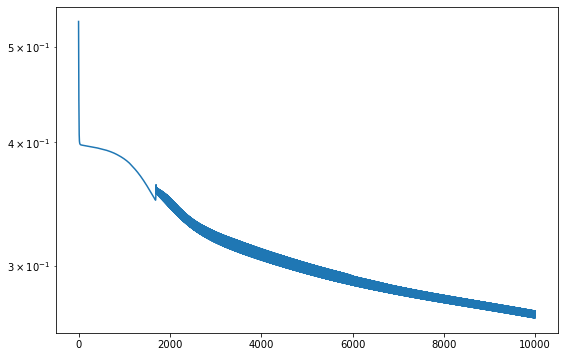

In [62]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [63]:
print('Difference b/w our weights & biases and PyTorch results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(torch.tensor(optWeights[i]).to(dtype=torch.float32)-Network._modules[str(i)].weight.data).max())
    print(abs(torch.tensor(optBiases[i]).to(dtype=torch.float32)-Network._modules[str(i)].bias.data).max())

Difference b/w our weights & biases and PyTorch results:

Layer :  1
tensor(0.0002)
tensor(2.8326e-06)

Layer :  2
tensor(8.7917e-06)
tensor(1.8869e-06)

Layer :  3
tensor(1.3545e-05)
tensor(1.5184e-05)


## Predictions on the test set

In [80]:
# make probability predictions with the model
predictionsTorch = Network(torch.from_numpy(inputs_test)).detach().numpy()
print(predictionsTorch) # Probabilities

predictions_max_int = (predictionsTorch == predictionsTorch.max(axis=1)[:,None]).astype(float)
print(predictions_max_int) # Maximum probability returned as 1

[[3.00308675e-01 5.29750109e-01 1.10053390e-01 1.67979430e-02
  3.32460441e-02 9.84391104e-03]
 [5.04086077e-01 3.45622480e-01 1.26537696e-01 4.23035212e-03
  1.65403523e-02 2.98303436e-03]
 [3.46756399e-01 4.82239217e-01 1.18403524e-01 1.24477940e-02
  3.21212746e-02 8.03184137e-03]
 [4.40383762e-01 4.17744875e-01 1.17639095e-01 6.34129578e-03
  1.51433498e-02 2.74750078e-03]
 [5.94829440e-01 2.63951480e-01 1.26041830e-01 2.12876988e-03
  1.12541271e-02 1.79439457e-03]
 [3.99576902e-01 4.45942104e-01 1.19272903e-01 8.60864110e-03
  2.20712908e-02 4.52822773e-03]
 [4.08650309e-01 4.55680132e-01 1.10879660e-01 7.70859700e-03
  1.46057326e-02 2.47560954e-03]
 [4.37080503e-01 4.19938534e-01 1.18020028e-01 6.48076460e-03
  1.55465789e-02 2.93356739e-03]
 [2.59322494e-01 5.21474361e-01 1.11940347e-01 2.23238654e-02
  5.99819310e-02 2.49570534e-02]
 [3.47370088e-01 4.79151607e-01 1.19605087e-01 1.23778246e-02
  3.24186012e-02 9.07667074e-03]
 [3.92662674e-01 4.43099111e-01 1.22642957e-01 9.0

In [81]:
# We need to use argmax as one hot encodings are not supported by confusion matrix
confusion_matrix(outputs_test.argmax(axis=1), predictions_max_int.argmax(axis=1))

array([[ 6,  7,  0,  0,  0,  0],
       [ 4, 18,  0,  2,  0,  0],
       [ 3,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  6]])